<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Working-with-Multidimensional-Coordinates" data-toc-modified-id="Working-with-Multidimensional-Coordinates-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Working with Multidimensional Coordinates</a></span><ul class="toc-item"><li><span><a href="#Plotting" data-toc-modified-id="Plotting-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Plotting</a></span></li><li><span><a href="#Multidimensional-Groupby" data-toc-modified-id="Multidimensional-Groupby-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Multidimensional Groupby</a></span></li></ul></li></ul></div>

# Working with Multidimensional Coordinates

Author: [Ryan Abernathey](https://github.com/rabernat)

Many datasets have _physical coordinates_ which differ from their _logical coordinates_. Xarray provides several ways to plot and analyze such datasets.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
from matplotlib import pyplot as plt

print("numpy version  : ", np.__version__)
print("pandas version : ", pd.__version__)
print("xarray version   : ", xr.__version__)

numpy version  :  1.14.3
pandas version :  0.23.4
xarray version   :  0.11.0+9.g22a5763e


As an example, consider this dataset from the [xarray-data](https://github.com/pydata/xarray-data) repository.

In [3]:
ds = xr.tutorial.open_dataset('rasm').load()
ds

<xarray.Dataset>
Dimensions:  (time: 36, x: 275, y: 205)
Coordinates:
  * time     (time) object 1980-09-16 12:00:00 ... 1983-08-17 00:00:00
    xc       (y, x) float64 189.2 189.4 189.6 189.7 ... 17.65 17.4 17.15 16.91
    yc       (y, x) float64 16.53 16.78 17.02 17.27 ... 28.26 28.01 27.76 27.51
Dimensions without coordinates: x, y
Data variables:
    Tair     (time, y, x) float64 nan nan nan nan nan ... 29.8 28.66 28.19 28.21
Attributes:
    title:                     /workspace/jhamman/processed/R1002RBRxaaa01a/l...
    institution:               U.W.
    source:                    RACM R1002RBRxaaa01a
    output_frequency:          daily
    output_mode:               averaged
    convention:                CF-1.4
    references:                Based on the initial model of Liang et al., 19...
    comment:                   Output from the Variable Infiltration Capacity...
    nco_openmp_thread_number:  1
    NCO:                       "4.6.0"
    history:                   Tue D

In this example, the _logical coordinates_ are `x` and `y`, while the _physical coordinates_ are `xc` and `yc`, which represent the latitudes and longitude of the data.

In [4]:
print(ds.xc.attrs)
print(ds.yc.attrs)

OrderedDict([('long_name', 'longitude of grid cell center'), ('units', 'degrees_east'), ('bounds', 'xv')])
OrderedDict([('long_name', 'latitude of grid cell center'), ('units', 'degrees_north'), ('bounds', 'yv')])


## Plotting ##

Let's examine these coordinate variables by plotting them.

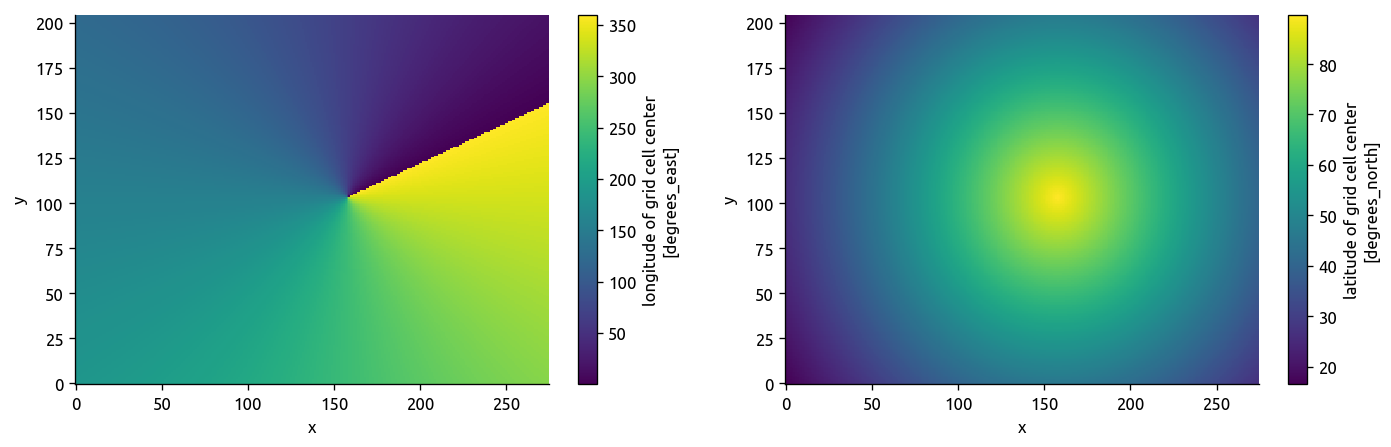

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
ds.xc.plot(ax=ax1)
ds.yc.plot(ax=ax2)

Note that the variables `xc` (longitude) and `yc` (latitude) are two-dimensional scalar fields.

If we try to plot the data variable `Tair`, by default we get the logical coordinates.

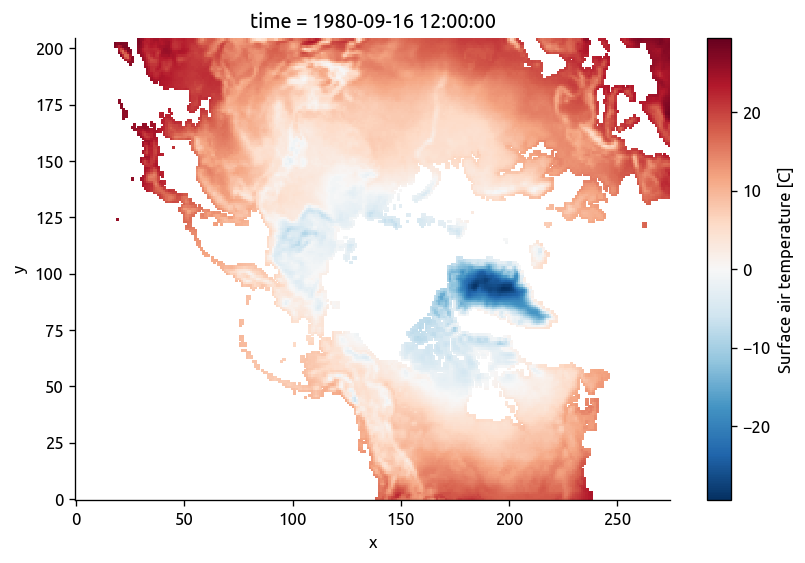

In [6]:
ds.Tair[0].plot()

In order to visualize the data on a conventional latitude-longitude grid, we can take advantage of xarray's ability to apply [cartopy](http://scitools.org.uk/cartopy/index.html) map projections.

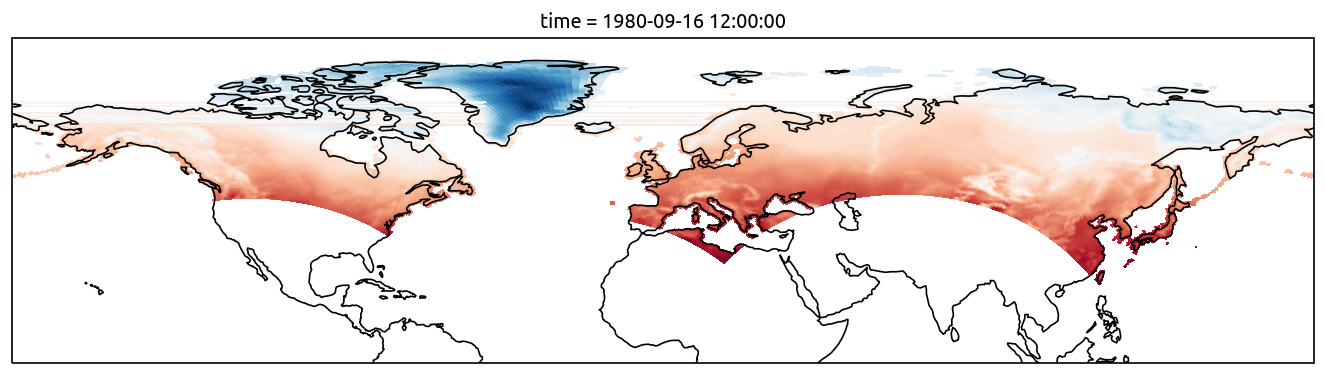

In [8]:
plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds.Tair[0].plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='xc', y='yc', add_colorbar=False)
ax.coastlines()
ax.set_ylim([0,90]);

## Multidimensional Groupby ##

The above example allowed us to visualize the data on a regular latitude-longitude grid. But what if we want to do a calculation that involves grouping over one of these physical coordinates (rather than the logical coordinates), for example, calculating the mean temperature at each latitude. This can be achieved using xarray's `groupby` function, which accepts multidimensional variables. By default, `groupby` will use every unique value in the variable, which is probably not what we want. Instead, we can use the `groupby_bins` function to specify the output coordinates of the group. 

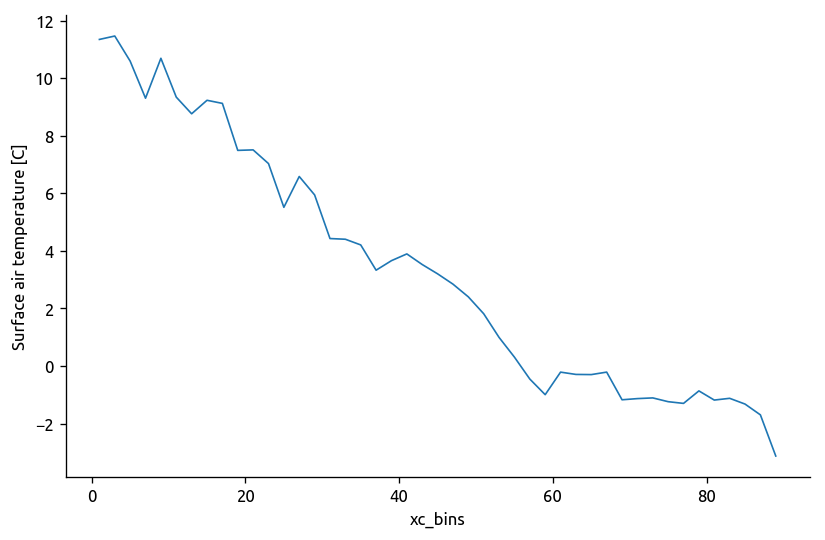

In [10]:
# define two-degree wide latitude bins
lat_bins = np.arange(0,91,2)
# define a label for each bin corresponding to the central latitude
lat_center = np.arange(1,90,2)
# group according to those bins and take the mean
Tair_lat_mean = ds.Tair.groupby_bins('xc', lat_bins, labels=lat_center).mean(dim=xr.ALL_DIMS)
# plot the result
Tair_lat_mean.plot()

Note that the resulting coordinate for the `groupby_bins` operation got the `_bins` suffix appended: `xc_bins`. This help us distinguish it from the original multidimensional variable `xc`.